# HVNM Tutorial 01: Flow Curve NLSQ→NUTS

## Introduction

At steady state under constant shear rate $\dot{\gamma}$, the HVNM E-network and I-network stresses vanish ($\sigma_E = \sigma_I = 0$) because natural states track the deformation via TST kinetics. Only the **D-network provides viscous dissipation**: $\sigma_{ss} = \eta_D \dot{\gamma}$ with $\eta_D = G_D / k_{d,D}$. The flow curve therefore constrains exactly **2 parameters**: $G_D$ (modulus) and $k_{d,D}$ (rate). This tutorial fits ethyl cellulose 7% shear-thinning data using NLSQ for point estimates, then NUTS for full Bayesian posteriors with ArviZ diagnostics (R-hat, ESS, posterior predictive checks).

> **Handbook:** See [HVNM Protocol Derivations](../../docs/source/models/hvnm/hvnm_protocols.rst) for steady-state analytical solution and [Knowledge Extraction](../../docs/source/models/hvnm/hvnm_knowledge.rst) for $\phi$-independence validation.

## Learning Objectives

- Fit steady shear flow curve with HVNM (2-parameter inference)
- Use log-space residuals for decades-spanning data
- Warm-start NUTS with NLSQ estimates
- Interpret posteriors: $\tau_D = 1/k_{d,D}$, $\eta_D = G_D / k_{d,D}$

## Prerequisites
- **Notebook 08** — Data intake and QC workflows

## Estimated Runtime
- NLSQ: ~5 s | NUTS: ~30 s (FAST_MODE) / ~5 min (production)

## 1. Setup

In [1]:
import sys
import time

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax openpyxl
    import os
    os.environ["JAX_ENABLE_X64"] = "true"

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import HVNMLocal

jax, jnp = safe_import_jax()
verify_float64()

sys.path.insert(0, "../..")
from examples.utils.hvnm_tutorial_utils import (
    configure_hvnm_for_fit,
    get_bayesian_config,
    get_fast_mode,
    get_nlsq_values,
    get_output_dir,
    load_ec_flow_curve,
    plot_fit_comparison,
    plot_ppc,
    plot_trace_and_forest,
    print_convergence,
    print_parameter_table,
    save_figure,
    save_results,
    setup_style,
)

setup_style()
print(f"JAX {jax.__version__}, devices: {jax.devices()}")
print(f"FAST_MODE: {get_fast_mode()}")
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

JAX 0.8.3, devices: [CpuDevice(id=0)]
FAST_MODE: True


## 2. Load and Inspect Data

Protocol: flow_curve
  Points: 43 / 43
  x range: [0.1, 1000]
  y range: [0.419, 869]
  material: Ethyl Cellulose 07.00 wt%
  source: pyRheo demos
  units_x: 1/s
  units_y: Pa


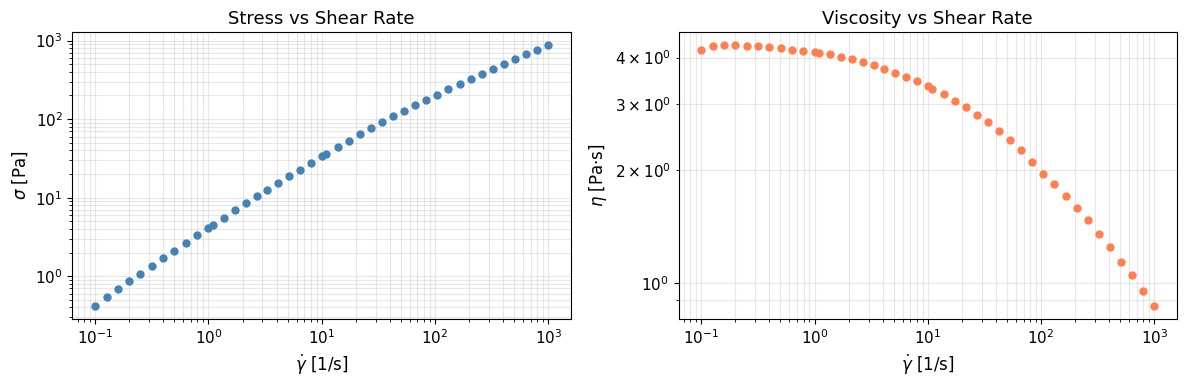

In [3]:
data = load_ec_flow_curve("07-00")
print(data.summary())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.loglog(data.x, data.y, 'o', ms=5, color='steelblue')
ax1.set_xlabel(data.x_label)
ax1.set_ylabel(data.y_label)
ax1.set_title('Stress vs Shear Rate')
ax1.grid(True, alpha=0.3, which='both')

ax2.loglog(data.x, data.y2, 'o', ms=5, color='coral')
ax2.set_xlabel(data.x_label)
ax2.set_ylabel(data.y2_label)
ax2.set_title('Viscosity vs Shear Rate')
ax2.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()

## 3. HVNM Model Configuration

For the flow curve, only `G_D` and `k_d_D` are identifiable. All other HVNM
parameters are fixed at defaults (they don't affect steady-state stress).

In [4]:
model = HVNMLocal(include_dissociative=True)
fit_params = configure_hvnm_for_fit(
    model,
    protocol="flow_curve",
    overrides={
        "G_D": 10.0,     # Initial guess (will be fitted)
        "k_d_D": 100.0,  # Initial guess
    },
)

print(f"Fittable parameters: {fit_params}")
print(f"\nInitial values:")
for p in fit_params:
    val = model.parameters.get_value(p)
    lo, hi = model.parameters[p].bounds
    print(f"  {p}: {val:.4g}  bounds=[{lo:.4g}, {hi:.4g}]")

Fittable parameters: ['G_D', 'k_d_D']

Initial values:
  G_D: 10  bounds=[0, 1e+08]
  k_d_D: 100  bounds=[1e-06, 1e+06]


## 4. NLSQ Fitting

We use log-space residuals for the flow curve (standard practice for data
spanning multiple decades).

In [5]:
t0 = time.time()
model.fit(
    data.x_masked,
    data.y_masked,
    test_mode="flow_curve",
    use_log_residuals=True,
    max_iter=2000,
)
nlsq_time = time.time() - t0

nlsq_vals = get_nlsq_values(model, fit_params)
print(f"\nNLSQ completed in {nlsq_time:.1f} s")
print(f"Fitted parameters:")
for p, v in nlsq_vals.items():
    print(f"  {p} = {v:.6g}")

# Physical interpretation
tau_D = 1.0 / nlsq_vals['k_d_D']
eta_D = nlsq_vals['G_D'] / nlsq_vals['k_d_D']
print(f"\nDerived quantities:")
print(f"  tau_D = 1/k_d_D = {tau_D:.4g} s")
print(f"  eta_D = G_D/k_d_D = {eta_D:.4g} Pa.s")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=15 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.507441s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=1 | final_cost=14.8878 | elapsed=1.507s | final_gradient_norm=3.4843e+07



NLSQ completed in 1.9 s
Fitted parameters:
  G_D = 43.176
  k_d_D = 100

Derived quantities:
  tau_D = 1/k_d_D = 0.01 s
  eta_D = G_D/k_d_D = 0.4318 Pa.s


Figure saved: /Users/b80985/Projects/rheojax/examples/hvnm/../../examples/utils/../figures/hvnm/hvnm_01_flow_nlsq_fit.png


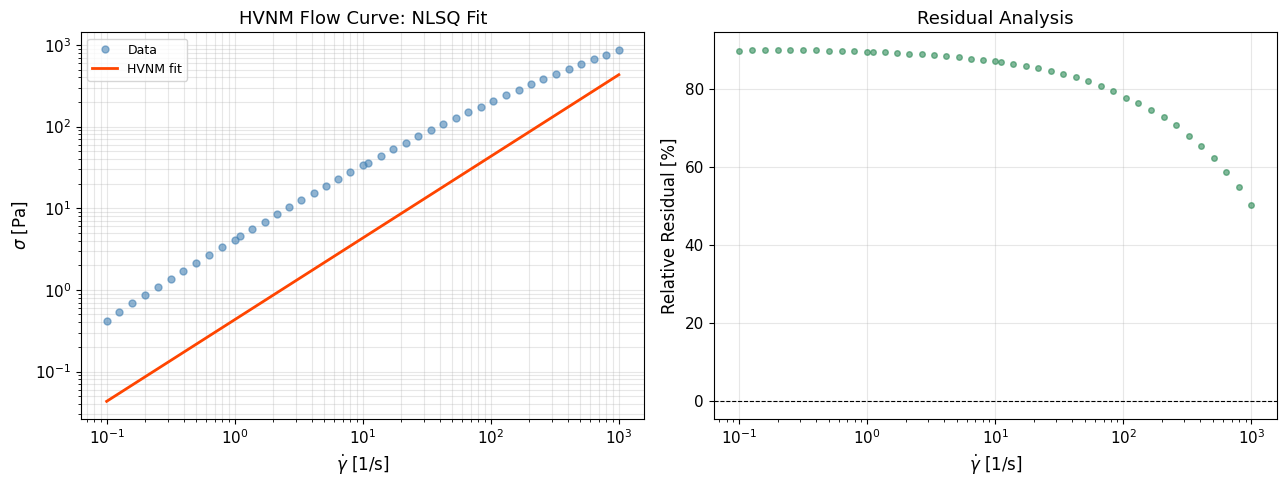

In [6]:
fig = plot_fit_comparison(data, model, title="HVNM Flow Curve: NLSQ Fit")
save_figure(fig, "hvnm_01_flow_nlsq_fit.png")
plt.show()

## 5. Bayesian Inference (NUTS)

We use the NLSQ result as a warm-start for NumPyro NUTS sampling.
The priors are consistent with the parameter bounds in the ParameterSet.

In [7]:
bayes_cfg = get_bayesian_config()
print(f"Bayesian config: {bayes_cfg}")

t0 = time.time()
result = model.fit_bayesian(
    data.x_masked,
    data.y_masked,
    test_mode="flow_curve",
    **bayes_cfg,
)
nuts_time = time.time() - t0
print(f"\nNUTS completed in {nuts_time:.1f} s")

Bayesian config: {'num_warmup': 50, 'num_samples': 100, 'num_chains': 1}


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:01<03:02,  1.23s/it, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:  21%|██▏       | 32/150 [00:01<00:03, 32.97it/s, 255 steps of size 3.68e-02. acc. prob=0.83]

sample:  41%|████▏     | 62/150 [00:01<00:01, 67.31it/s, 255 steps of size 1.91e-02. acc. prob=0.96]

sample:  63%|██████▎   | 95/150 [00:01<00:00, 108.04it/s, 127 steps of size 1.91e-02. acc. prob=0.93]

sample:  87%|████████▋ | 130/150 [00:01<00:00, 151.62it/s, 127 steps of size 1.91e-02. acc. prob=0.93]

sample: 100%|██████████| 150/150 [00:01<00:00, 88.54it/s, 127 steps of size 1.91e-02. acc. prob=0.93] 


NUTS completed in 4.1 s


## 6. Convergence Diagnostics

In [8]:
converged = print_convergence(result, fit_params)
print()
print_parameter_table(fit_params, nlsq_vals, result.posterior_samples)

Convergence Diagnostics
   Parameter     R-hat       ESS
--------------------------------------------------
         G_D    1.0169       137
       k_d_D    1.0263       130

Divergences: 0
Convergence: PASSED

Parameter Comparison
       Param          NLSQ    Bayes(med)                    95% CI
------------------------------------------------------------------
         G_D         43.18     7.294e+05  [1.743e+05, 1.022e+06]
       k_d_D           100     7.177e+05  [1.663e+05, 9.745e+05]


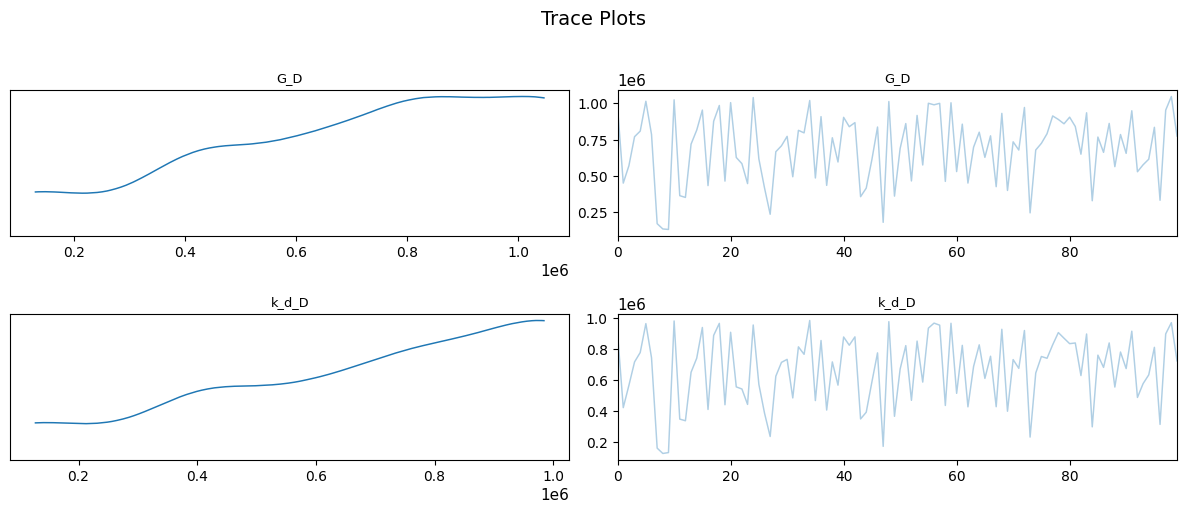

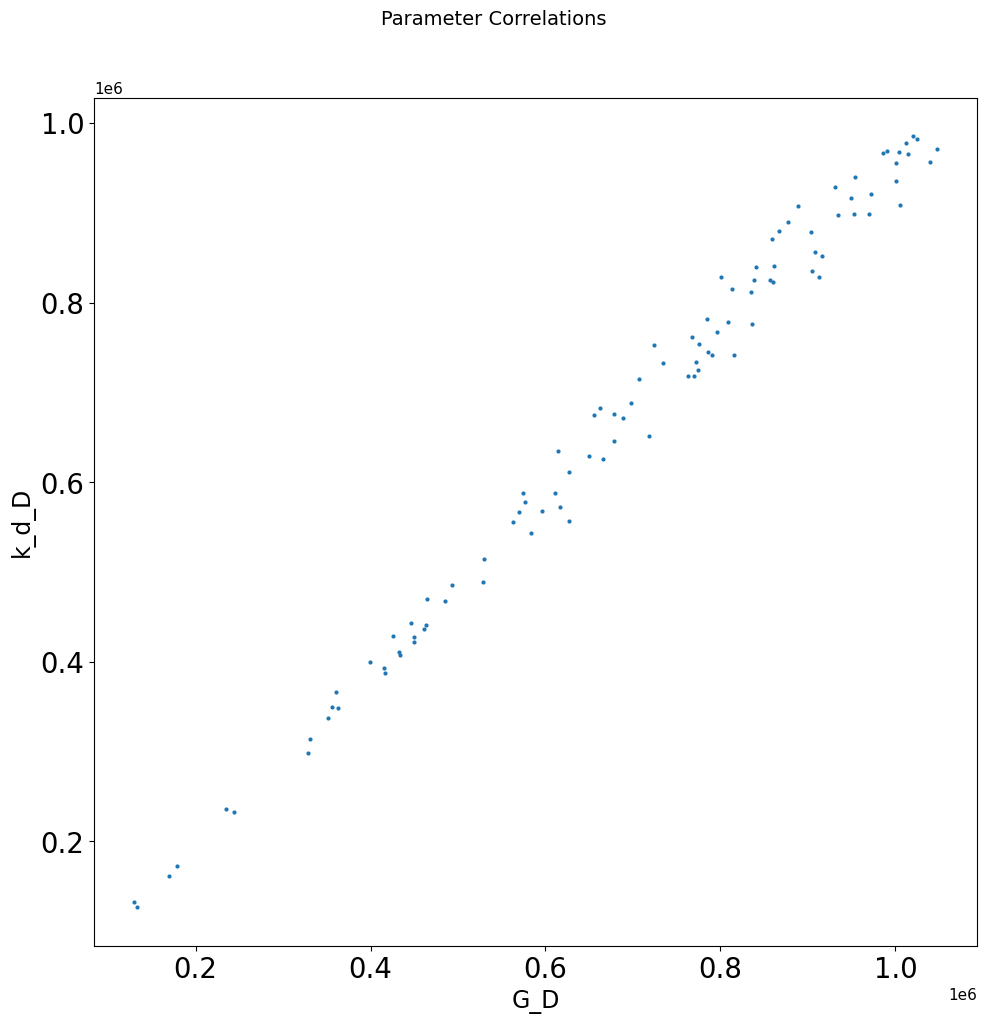

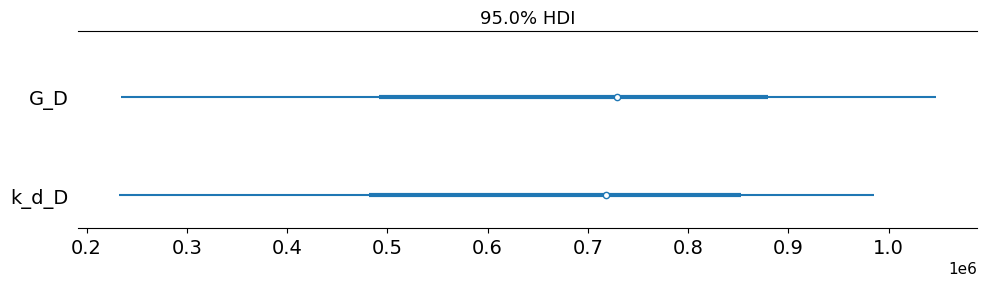

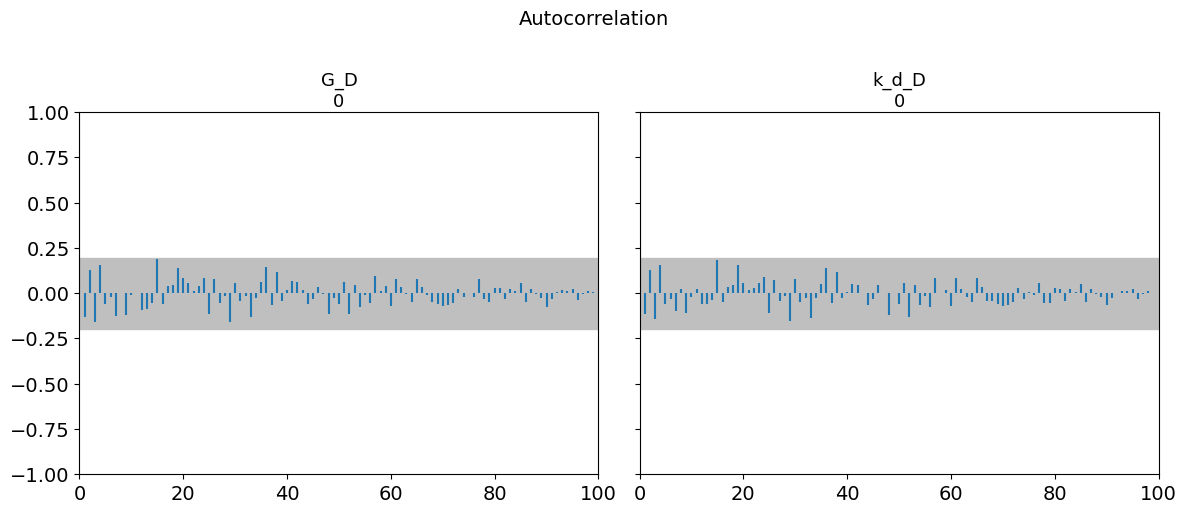

In [9]:
display_arviz_diagnostics(result, fit_params, fast_mode=get_fast_mode())

## 7. Posterior Predictive Check

Figure saved: /Users/b80985/Projects/rheojax/examples/hvnm/../../examples/utils/../figures/hvnm/hvnm_01_flow_ppc.png


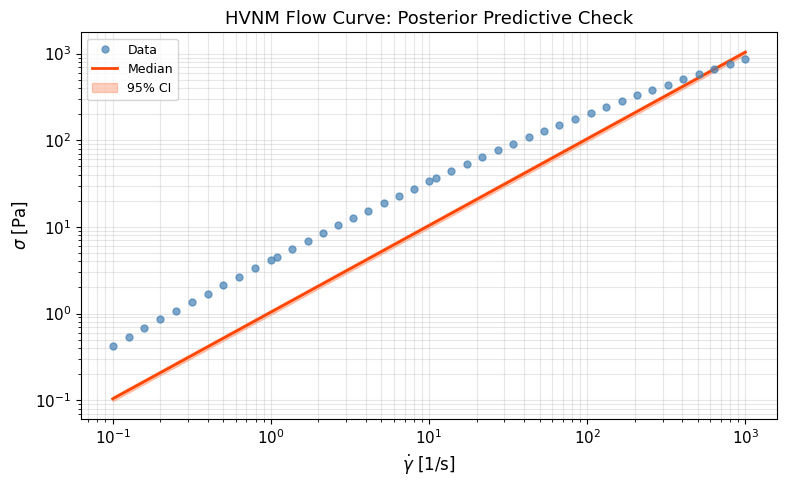

In [10]:
fig = plot_ppc(
    data, model, result.posterior_samples, fit_params,
    title="HVNM Flow Curve: Posterior Predictive Check",
)
save_figure(fig, "hvnm_01_flow_ppc.png")
plt.show()

## 8. Save Results

In [11]:
out_dir = get_output_dir("flow_curve")
save_results(
    out_dir, model, result,
    param_names=fit_params,
    extra_meta={"dataset": "EC_7pct", "protocol": "flow_curve"},
)

Saved to /Users/b80985/Projects/rheojax/examples/hvnm/../../examples/utils/../outputs/hvnm/flow_curve/


## Key Takeaways

1. **Flow curve constrains 2 params**: $G_D$ and $k_{d,D}$ only (E/I networks vanish at SS)
2. **Log-space residuals**: Standard for decades-spanning rheological data
3. **NLSQ warm-start**: Dramatically improves NUTS efficiency (fewer divergences)
4. **Derived quantities**: $\tau_D = 1/k_{d,D}$ (relaxation time), $\eta_D = G_D / k_{d,D}$ (zero-shear viscosity)
5. **Cross-protocol**: Use with SAOS (NB13) or global fitting (NB15) to constrain E/I networks

## Further Reading

**Handbook Documentation:**
- [HVNM Protocol Derivations](../../docs/source/models/hvnm/hvnm_protocols.rst) — Steady-state analytical solution
- [HVNM Knowledge Extraction](../../docs/source/models/hvnm/hvnm_knowledge.rst) — Why $\phi$-independent, cross-protocol workflows

**Key References:**
1. Karim, M.R., Vernerey, F. & Sain, T. (2025). *Macromolecules*, 58(10), 4899-4912.

## Next Notebooks

- **Notebook 10**: Creep compliance NLSQ/NUTS
- **Notebook 13**: SAOS NLSQ/NUTS — Full network moduli
- **Notebook 15**: Global multi-protocol — Joint inference